# 支持向量机 Support Vector Machine
## 算法实现 implementation of algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### 数据集 Dataset

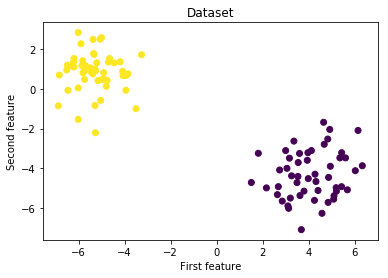

In [2]:
X, y = make_blobs(n_samples=100, centers=2, random_state=123)
y[y==0]=-1
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [3]:
class SupportVectorMachine():
    def __init__(self):
        self.weights = None
        self.bias = 0
        self.support_vectors_ = []

    def fit(self, X, y, slack, toler, n_iters):
        """
        SMO 算法
        """
        itercount = 0
        n_samples, n_features = X.shape
        gram = np.dot(X, X.T)
        b = 0
        alpha = np.zeros(n_samples)
        while itercount < n_iters:
            updated = False
            for i in range(n_samples):
                # alpha[i] 作为第一变量 i
                fXi = np.sum(alpha*y*gram[i]) + b
                Ei = fXi - y[i]
                # 判定 KKT 条件
                if (y[i] * Ei < -toler and alpha[i] < slack) or (y[i] * Ei > toler and alpha[i] > 0):
                    # alpha[j] 作为第二变量 j 
                    j = np.random.choice([x for x in range(n_samples) if not x == i])
                    # 计算Ej
                    fXj = np.sum(alpha*y*gram[j]) + b
                    Ej = fXj - y[j]
                    # 保存 第一第二变量
                    alphaIold = alpha[i].copy()
                    alphaJold = alpha[j].copy()
                    # 计算上下界HL
                    if y[i] == y[j]:
                        L = max(0, alpha[i]+alpha[j]-slack)
                        H = min(slack, alpha[i]+alpha[j])
                    else:
                        L = max(0, alpha[j]-alpha[i])
                        H = min(slack, slack + alpha[j] - alpha[i])
                    if L == H: continue
                    # 计算eta
                    eta = -2.0 * np.dot(X[i], X[j]) + np.dot(X[i], X[i]) + np.dot(X[j], X[j])
                    if eta < 0: continue
                    # 更新 第二变量 j
                    alpha[j] += y[j]*(Ei-Ej)/eta
                    # 修剪 第二变量 j
                    if alpha[j] > H: alpha[j] = H
                    elif alpha[j] < L: alpha[j] = L
                    # 更新 第一变量 i
                    alpha[i] += y[j] * y[i] * (alphaJold - alpha[j])
                    # 更新 b
                    b1 = b - Ei - y[i] * (alpha[i] - alphaIold) * np.dot(X[i], X[i]) - y[j] * (alpha[j] - alphaJold) * np.dot(X[i], X[j])
                    b2 = b - Ej - y[i] * (alpha[i] - alphaIold) * np.dot(X[i], X[j]) - y[j] * (alpha[j] - alphaJold) * np.dot(X[j], X[j])
                    if 0 < alpha[i] and slack > alpha[i]: b = b1
                    elif 0 < alpha[i] and slack > alpha[j]: b = b2
                    else: b = (b1 + b2) / 2.0
                    updated = True
            if updated is False:
                itercount += 1
            else:
                itercount = 0
        self.weights = np.dot(alpha * y, X)
        self.bias = b
        self.support_vectors_ = X[alpha!=0]
        return self.weights, self.bias

    def predict(self, X):
        a = np.dot(X, self.weights) + self.bias
        return np.array([1 if elem > 0 else - 1 for elem in a])
    
    def decision_function(self, X):
        return (np.dot(X, self.weights) + self.bias)
    

### 测试 Testing

In [4]:
clf = SupportVectorMachine()
%time clf.fit(X, y, 1, 0.001, 40)

Wall time: 342 ms


(array([-0.31980869,  0.13483773]), 0.014200421227872025)

In [5]:
clf.support_vectors_

array([[-3.50355959, -0.99875038],
       [ 1.80628336, -3.23748621]])

### 决策边界可视化 Visualize decision boundary

In [6]:
def plot_decision_boundary(clf): 
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

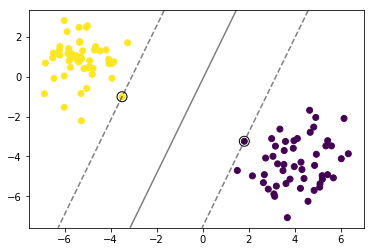

In [7]:
plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, facecolor='none', edgecolor='k')
plt.show()

## scikit-learn

In [8]:
from sklearn import svm

In [9]:
s_clf = svm.SVC(kernel='linear', C=1, tol=0.001, max_iter=40)
%time s_clf.fit(X, y)

Wall time: 981 µs


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=40, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
s_clf.support_vectors_

array([[ 1.80628336, -3.23748621],
       [-3.50355959, -0.99875038]])

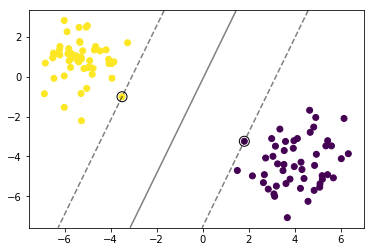

In [11]:
plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(s_clf)
plt.scatter(s_clf.support_vectors_[:, 0], s_clf.support_vectors_[:, 1], s=100, facecolor='none', edgecolor='k')
plt.show()